# Regresión Lasso como método para selección de variables
En este ejercicio intentaremos ver cómo Lasso sirve para como método de selección de variables.

In [6]:
# Importa librerías relevantes
import numpy as np
import pandas as pd

# scikit-learn
from sklearn.linear_model    import LogisticRegression, Lasso
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve, roc_auc_score
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn                 import preprocessing

Revisa la documentación de sklearn.datasets (https://scikit-learn.org/stable/datasets.html) para importar el data set de **Boston house prices**. ¿Cuál es la variable target del modelo?

In [245]:
# Importa los datos
from sklearn.datasets import load_boston
X,y = load_boston(return_X_y=True)
features = load_boston()['feature_names']

Haz un análisis exploratorio inicial y preprocesa los datos de tal manera que tu modelo tenga buen performance

In [104]:
# Normaliza los valores de las variables independientes
data_values = X
min_max_scaler = preprocessing.StandardScaler()
data_values = min_max_scaler.fit_transform(data_values)
X = data_values

In [105]:
# Parte los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

En la siguientes celdas define un proceso para encontrar el hyper parámetro alfa óptimo para una regresión Lasso. Posterior a ello, entrena un modelo Lasso para encontrar las variables más importantes para predecir la variable **y target** (revisa la documentación del data set)

In [106]:
# Define aquí el proceso para determinar el alpha óptimo a través de ejecutar un algoritmo de validación cruzada con K = 5
alphas = []
scores = []
# hyperparameter optimization
def hyper_lasso(X, y):
    best_alpha = 0
    highest_score = float('-inf')
    for alpha in np.arange(0.1,1000,0.1):
        lasso_reg = Lasso(alpha=alpha)
        alphas.append(alpha)
        curr_score = cross_val_score(lasso_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
        scores.append(curr_score)
        if curr_score > highest_score:
            highest_score = curr_score
            best_alpha = alpha
    return best_alpha

# Determina el mejor alpha para la regresión Lasso
alpha_opt = hyper_lasso(X_train, y_train)

In [107]:
# Entrena un modelo de regresión Lasso con el alpha óptimo
lasso_reg = Lasso(alpha=alpha_opt)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [108]:
# ¿Cuál es el valor alfa óptimo?
alpha_opt

0.1

In [109]:
# Muestra el score de R² para los sets de datos train y test
lasso_reg.score(X_train, y_train), lasso_reg.score(X_test, y_test)

(0.7036033498259772, 0.7729045748893623)

In [115]:
# ¿Cuáles son las variables más importantes para predecir la variable target?
importancia = np.abs(lasso_reg.coef_)
np.array(features)[importancia > 0]

array(['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO',
       'B', 'LSTAT'], dtype='<U7')

# Regresión Logítica
En esta sección vas a aprender a optimizar hyper parámetros para un regresión logística con diferentes términos de regularización. Usaremos un problema de clasificación binario para ello, es decir trataremos de predecir si un cliente hará o no default en un crédito. 
Utilizaremos el data set **credit_data.csv**, puedes ver el layout en la parte de abajo. 

| Feature name     | Variable Type | Description 
|------------------|---------------|--------------------------------------------------------
| customer_default (target) | Binary        | 1 = default in following month; 0 = no default 
| LIMIT_BAL        | Continuous    | Credit limit   
| SEX              | Categorical   | 1 = male; 2 = female
| EDUCATION        | Categorical   | 1 = graduate school; 2 = university; 3 = high school; 4 = others
| MARRIAGE         | Categorical   | 0 = unknown; 1 = married; 2 = single; 3 = others
| AGE              | Continuous    | Age in years  
| PAY1             | Categorical   | Repayment status in September, 2005 
| PAY2             | Categorical   | Repayment status in August, 2005 
| PAY3             | Categorical   | Repayment status in July, 2005 
| PAY4             | Categorical   | Repayment status in June, 2005 
| PAY5             | Categorical   | Repayment status in May, 2005 
| PAY6             | Categorical   | Repayment status in April, 2005 
| BILL_AMT1        | Continuous    | Balance in September, 2005  
| BILL_AMT2        | Continuous    | Balance in August, 2005  
| BILL_AMT3        | Continuous    | Balance in July, 2005  
| BILL_AMT4        | Continuous    | Balance in June, 2005 
| BILL_AMT5        | Continuous    | Balance in May, 2005  
| BILL_AMT6        | Continuous    | Balance in April, 2005  
| PAY_AMT1         | Continuous    | Amount paid in September, 2005
| PAY_AMT2         | Continuous    | Amount paid in August, 2005
| PAY_AMT3         | Continuous    | Amount paid in July, 2005
| PAY_AMT4         | Continuous    | Amount paid in June, 2005
| PAY_AMT5         | Continuous    | Amount paid in May, 2005
| PAY_AMT6         | Continuous    | Amount paid in April, 2005

In [7]:
# Librerías estándar
import numpy  as np
import pandas as pd

import itertools
import random

# Gráficas
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
sns.set(style="white")

# scikit-learn
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import Lasso
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split


# Ignorar warnings 
import warnings
warnings.filterwarnings('ignore')

# Para poder replicar los resultados de problemas aleatorios, es necesario definir una semilla
SEED = 1

In [8]:
# Define funciones que serán útiles
def grafica_matriz_confusion(cm, classes=[0,1], normalize=False, title='Matriz de confusión\n', cmap=plt.cm.Reds):
    """ 
    Función para mostrar la matriz de confusión de un problema de clasificación binario. 
    El parámetro cm puede ser el objeto resultante de ejecutar la función confusion_matrix() de la librería sklearn.
    
    Args:
        cm         matriz de confusión de sklearn
        classes    categorías de la variable target
        normalize  normaliza asignando el parámetro True
        title      string para definir el título para la gráfica
        cmap       mapa de colores
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max()
    text = [["VN =", "FN ="], ["FP =", "VP ="]]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "     {}".format(round (cm[i, j],2)), horizontalalignment="left",
                 color="white" if cm[i, j] > thresh else "black")
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, text[j][i] , horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Valor real')
    plt.xlabel('Predicción')
    
def grafica_curva_roc(fpr, tpr, title='Curva ROC', note=''):
    """
    Función para graficar la curva ROC
    Los parámetros fpr y tpr son el output de ejecutar la función roc_curve de sklearn
    
    Args:
        fpr        Tasa de falsos positivos 
        tpr        Tasa de verdaderos positivos
        title      sting para definir el título de la gráfica
        note       Nota para mostrar en la gráfica
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('Tasa de falsos positivos ')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()

## Regresión Logística con norma L1 cómo término regularizador
Haz todos los pasos necesarios para cargar el set de datos, exploración, preprocesamiento, selección de hyper parámetros, entrenamiento de una regresión logística con la norma L1 como término regularizador, y Evaluación de resultados.
**Hint: revisa la documentación de sklearn acerca del objeto LogisticRegression(), especialmente el parámetro penalty para saber cómo definir un modelo de Regresión Logística con norma L1. Se cuidadoso con el parámetro solver, pues dependerá de la norma que elijas**

In [9]:
# Load Data
data = pd.read_csv(r'data/credit_data.csv')

# One-hot-encode SEX and MARRIAGE  
data = pd.get_dummies(data = data, columns = ['SEX', 'MARRIAGE'])

# Drop the ID column
data = data.drop(columns = ['ID'], axis = 1)

# Sort Columns alphabetically
data = data.reindex(sorted(data.columns), axis=1)

# Move target variable to first column (not necessary, but easier to see)
data = data.set_index('customer_default').reset_index() 

# Select target
y = np.array(data['customer_default'])

# Select features 
features = list(set(list(data.columns)) - set(['customer_default']))
X = data.loc[:, features]

In [10]:
# Estandariza los valores de las variables independientes
data_values = X.values
min_max_scaler = preprocessing.StandardScaler()
data_values = min_max_scaler.fit_transform(data_values)
X = pd.DataFrame(data_values, columns=X.columns)

In [11]:
# Parte los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [15]:
# Define aquí el proceso para determinar el hyper parámetro C óptimo a través de ejecutar un algoritmo de validación cruzada con K = 5
C = []
scores = []
# hyperparameter optimization
def hyper_log_reg(X, y):
    best_C = 0
    highest_score = float('-inf')
    for c in np.arange(0.1,10,0.1):
        log_reg = LogisticRegression(C=c, penalty='l1', solver='liblinear')
        C.append(c)
        curr_score = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='roc_auc').mean()
        scores.append(curr_score)
        if curr_score > highest_score:
            highest_score = curr_score
            best_C = c
    return best_C

# Determina el mejor alpha para la regresión Lasso
C_opt = hyper_log_reg(X_train, y_train)

In [16]:
C_opt

9.9

In [237]:
log_reg = LogisticRegression(C=C_opt, penalty='l1', solver='liblinear')
log_reg.fit(X_train,y_train)

LogisticRegression(C=7.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [238]:
# Determina la predicción para y
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)

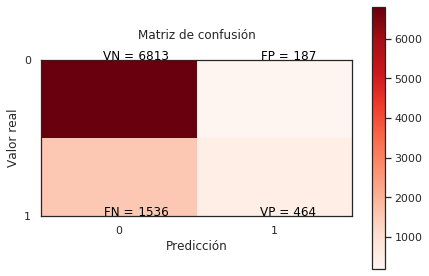

In [239]:
# Muestra la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)  
grafica_matriz_confusion(matriz_confusion)

In [240]:
# Cuántos errores cometimos?
error = matriz_confusion[0][1] + matriz_confusion[1][0]
print('# Errores =', error)
print('% Erroress =', error/len(y_pred))

# Errores = 1723
% Erroress = 0.19144444444444444


In [241]:
# Calcula la efectividad
efectividad = matriz_confusion[0][0] + matriz_confusion[1][1]
print('# Aciertos =', efectividad)
print('% Efectividad =', efectividad/len(y_pred))
print('Otra forma de calcular la efectividad =', 1-(error/len(y_pred)))

# Aciertos = 7277
% Efectividad = 0.8085555555555556
Otra forma de calcular la efectividad = 0.8085555555555556


In [242]:
# Calcula el recall y la precisión de la predicción
print('% Recall =', matriz_confusion[1][1]/(matriz_confusion[1][1] + matriz_confusion[1][0]))
print('% Precisión =', matriz_confusion[1][1]/(matriz_confusion[1][1] + matriz_confusion[0][1]))

% Recall = 0.232
% Precisión = 0.7127496159754224


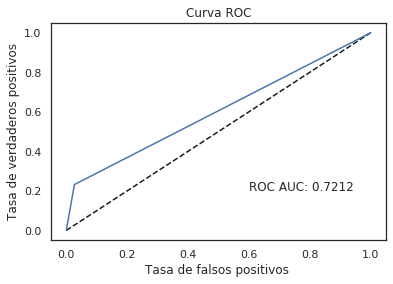

In [243]:
# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba[:,1])
grafica_curva_roc(fpr, tpr, 'Curva ROC', note='ROC AUC: {0:.4f}'.format(auc))

## Regresión Logística con norma L2 cómo término regularizador
Haz todos los pasos necesarios para cargar el set de datos, exploración, preprocesamiento, selección de hyper parámetros, entrenamiento de una regresión logística con la norma L2 como término regularizador, y Evaluación de resultados.
**Hint: revisa la documentación de sklearn acerca del objeto LogisticRegression(), especialmente el parámetro penalty para saber cómo definir un modelo de Regresión Logística con norma L2. Se cuidadoso con el parámetro solver, pues dependerá de la norma que elijas**

In [ ]:
# Se deja como ejercicio, pues es muy similar al ejercicio anterior, lo único que cambia es el término regularizador

## Regresión Logística con norma L1 + L2 cómo término regularizador
Haz todos los pasos necesarios para cargar el set de datos, exploración, preprocesamiento, selección de hyper parámetros, entrenamiento de una regresión logística con la norma L1 + L2 como término regularizador, y Evaluación de resultados.
**Hint: revisa la documentación de sklearn acerca del objeto LogisticRegression(), especialmente el parámetro penalty para saber cómo definir un modelo de Regresión Logística con norma L1 + L2. Se cuidadoso con el parámetro solver, pues dependerá de la norma que elijas**

In [ ]:
# Se deja como ejercicio, pues es muy similar al ejercicio anterior, lo único que cambia es el término regularizador

# [Stretch] Selecciona el modelo ganador, considera la métrica ROC AUC para hacer la evaluación